Now it's time to build our recurrent neural network to predict the traffic.Considering we will combine the squares to make the traffic, we will only have 144 registers, in which is too few to build a neural network. To address the problem, I concatened two months of the big data Italia telecom to form the ultimate dataset (for more details, please see dataset_mounting.ipynb). So, we will proceed with the preprocessing.

In [374]:
# Libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [5]:
b1 = pd.read_csv('main_pt1.csv')

In [6]:
b2 = pd.read_csv('main_pt2.csv')

In [7]:
dataset = pd.concat((b1,b2), axis = 0)
dataset = dataset.drop(['Unnamed: 0'], axis =1)

# Preprocessing

In [ ]:
# Now we are going to combine Fronthaul_Gbps by time. Then first, we must convert times

In [254]:
dataset.head(20)

,Time_Interval,Fronthaul_Gbps
0,0.0,15926.859120
1,0.1,15280.470110
2,0.2,14464.173095
3,0.3,14124.630539
4,0.4,13911.727145
5,0.5,12397.925421
6,1.0,13312.808643
7,1.1,12683.929783
8,1.2,11679.444142
9,1.3,11083.942238


In [263]:
dataset.reset_index(drop=True)

,Time_Interval,Fronthaul_Gbps
0,0.0,15926.859120
1,0.1,15280.470110
2,0.2,14464.173095
3,0.3,14124.630539
4,0.4,13911.727145
...,...,...
8635,23.1,5310.627897
8636,23.2,5422.417069
8637,23.3,5348.841783
8638,23.4,5072.057402


In [264]:
len(dataset)

8640

In [265]:
# Let's check if there is any null values
dataset.isnull().values.any()

False

<AxesSubplot:xlabel='Fronthaul_Gbps'>

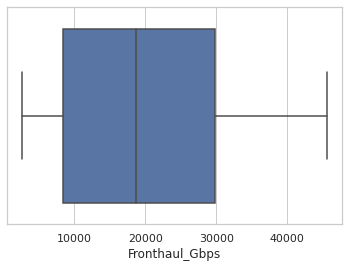

In [266]:
# Let's check if there is any outliers
sns.set_theme(style="whitegrid")
sns.boxplot(x=dataset["Fronthaul_Gbps"])

In LSTM, the previous values are the predictors of the regression. In this case, we need to slice the dataset to get only the column Fronthaul_Gbps

In [43]:
df6 = dataset.iloc[:, 2:3].values

In [169]:
df_test = dataset.iloc[:, 2:3]

In [44]:
df6

array([[15926.85912024],
       [15280.4701099 ],
       [14464.17309474],
       ...,
       [ 5348.84178281],
       [ 5072.05740179],
       [ 4998.27903553]])

In [ ]:
# No outliers! If so, we would have been replaced by NaN values and then, interpoplate the dataset.

In [45]:
#To become the training faster, we must normalize the data
normalizer = MinMaxScaler(feature_range=(0,1))

In [46]:
df6_normalized = normalizer.fit_transform(df6)

In [47]:
df6_normalized

array([[0.30856786],
       [0.29347866],
       [0.27442316],
       ...,
       [0.0616364 ],
       [0.05517519],
       [0.05345292]])

In [319]:
# Now we have to split the data between training and test. I will use 59 days to build the model and 1 day to
# test it.
training = df6_normalized[:-144]

In [320]:
len(training)

8496

In [321]:
test = df6_normalized[-144:]

In [322]:
len(test) # I want to predict a day

144

In [323]:
training

array([[0.30856786],
       [0.29347866],
       [0.27442316],
       ...,
       [0.40880518],
       [0.37382913],
       [0.35707067]])

In [324]:
test

array([[0.05357412],
       [0.04982646],
       [0.04879946],
       [0.04724845],
       [0.0451094 ],
       [0.03967233],
       [0.03834045],
       [0.03135011],
       [0.02795166],
       [0.02614182],
       [0.02262482],
       [0.02313284],
       [0.02120472],
       [0.01324923],
       [0.02044191],
       [0.01129769],
       [0.00722555],
       [0.00525717],
       [0.00645245],
       [0.00300233],
       [0.00405196],
       [0.00065779],
       [0.00207028],
       [0.01019365],
       [0.00703038],
       [0.00789778],
       [0.00700392],
       [0.00476992],
       [0.00304114],
       [0.0050886 ],
       [0.00191516],
       [0.00426569],
       [0.00879329],
       [0.00571431],
       [0.00514625],
       [0.00659621],
       [0.00280041],
       [0.00292982],
       [0.00868093],
       [0.00961609],
       [0.00783694],
       [0.00641728],
       [0.00570762],
       [0.00437646],
       [0.00915187],
       [0.00632854],
       [0.00627318],
       [0.010

In [325]:
#Time to create predictors and classes
predictors = []
classes = []
for i in range(2, len(training)): # I want to use 20 minutes to predict the next 10 minutes
    predictors.append(training[i-2:i,0])
    classes.append(training[i,0])

In [326]:
# Required to pass as parameters to neural network in keras
predictors, classes = np.array(predictors), np.array(classes)

In [327]:
classes.shape

(8494,)

In [328]:
predictors.shape

(8494, 2)

In [329]:
'''The tensorflow requires three-dimensional structure: (Batch_size, timesteps, Input_dim)
 The batch size is the size of dataset training, or array, timesteps is the time interval
 for predictions (in this case, 5 timesteps (50 minutes)), and then the input_dim, that is
 the number of attributes predictors, that is 1.
 
 ''' 
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1],1))

In [330]:
predictors.shape

(8494, 2, 1)

In [337]:
# Now it's time to create the neural network
regressor = Sequential()
regressor.add(LSTM(units = 20, return_sequences = True, input_shape = (predictors.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 20))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [338]:
history = regressor.fit(predictors, classes, epochs = 100, shuffle = False, batch_size = 32,
                        validation_split = 0.1)

Epoch 1/100
239/239 [==============================] - 6s 9ms/step - loss: 0.0554 - mean_absolute_error: 0.1878 - val_loss: 0.0082 - val_mean_absolute_error: 0.0814
Epoch 2/100
239/239 [==============================] - 1s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0866 - val_loss: 0.0040 - val_mean_absolute_error: 0.0526
Epoch 3/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0088 - mean_absolute_error: 0.0690 - val_loss: 0.0021 - val_mean_absolute_error: 0.0356
Epoch 4/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0561 - val_loss: 0.0022 - val_mean_absolute_error: 0.0353
Epoch 5/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0053 - mean_absolute_error: 0.0522 - val_loss: 0.0014 - val_mean_absolute_error: 0.0291
Epoch 6/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0503 - val_loss: 0.0021 - val_mean_absolute_error: 0.0341
Epoch 7/10

239/239 [==============================] - 1s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0404 - val_loss: 9.5174e-04 - val_mean_absolute_error: 0.0226
Epoch 51/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0398 - val_loss: 9.5805e-04 - val_mean_absolute_error: 0.0230
Epoch 52/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0011 - val_mean_absolute_error: 0.0249
Epoch 53/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0405 - val_loss: 0.0010 - val_mean_absolute_error: 0.0236
Epoch 54/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0403 - val_loss: 9.5810e-04 - val_mean_absolute_error: 0.0230
Epoch 55/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0027 - mean_absolute_error: 0.0398 - val_loss: 9.5558e-04 - val_mean_absolute_error: 0.0225
E

239/239 [==============================] - 1s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0382 - val_loss: 8.7337e-04 - val_mean_absolute_error: 0.0218
Epoch 99/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0375 - val_loss: 9.2873e-04 - val_mean_absolute_error: 0.0229
Epoch 100/100
239/239 [==============================] - 1s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0378 - val_loss: 8.1565e-04 - val_mean_absolute_error: 0.0202


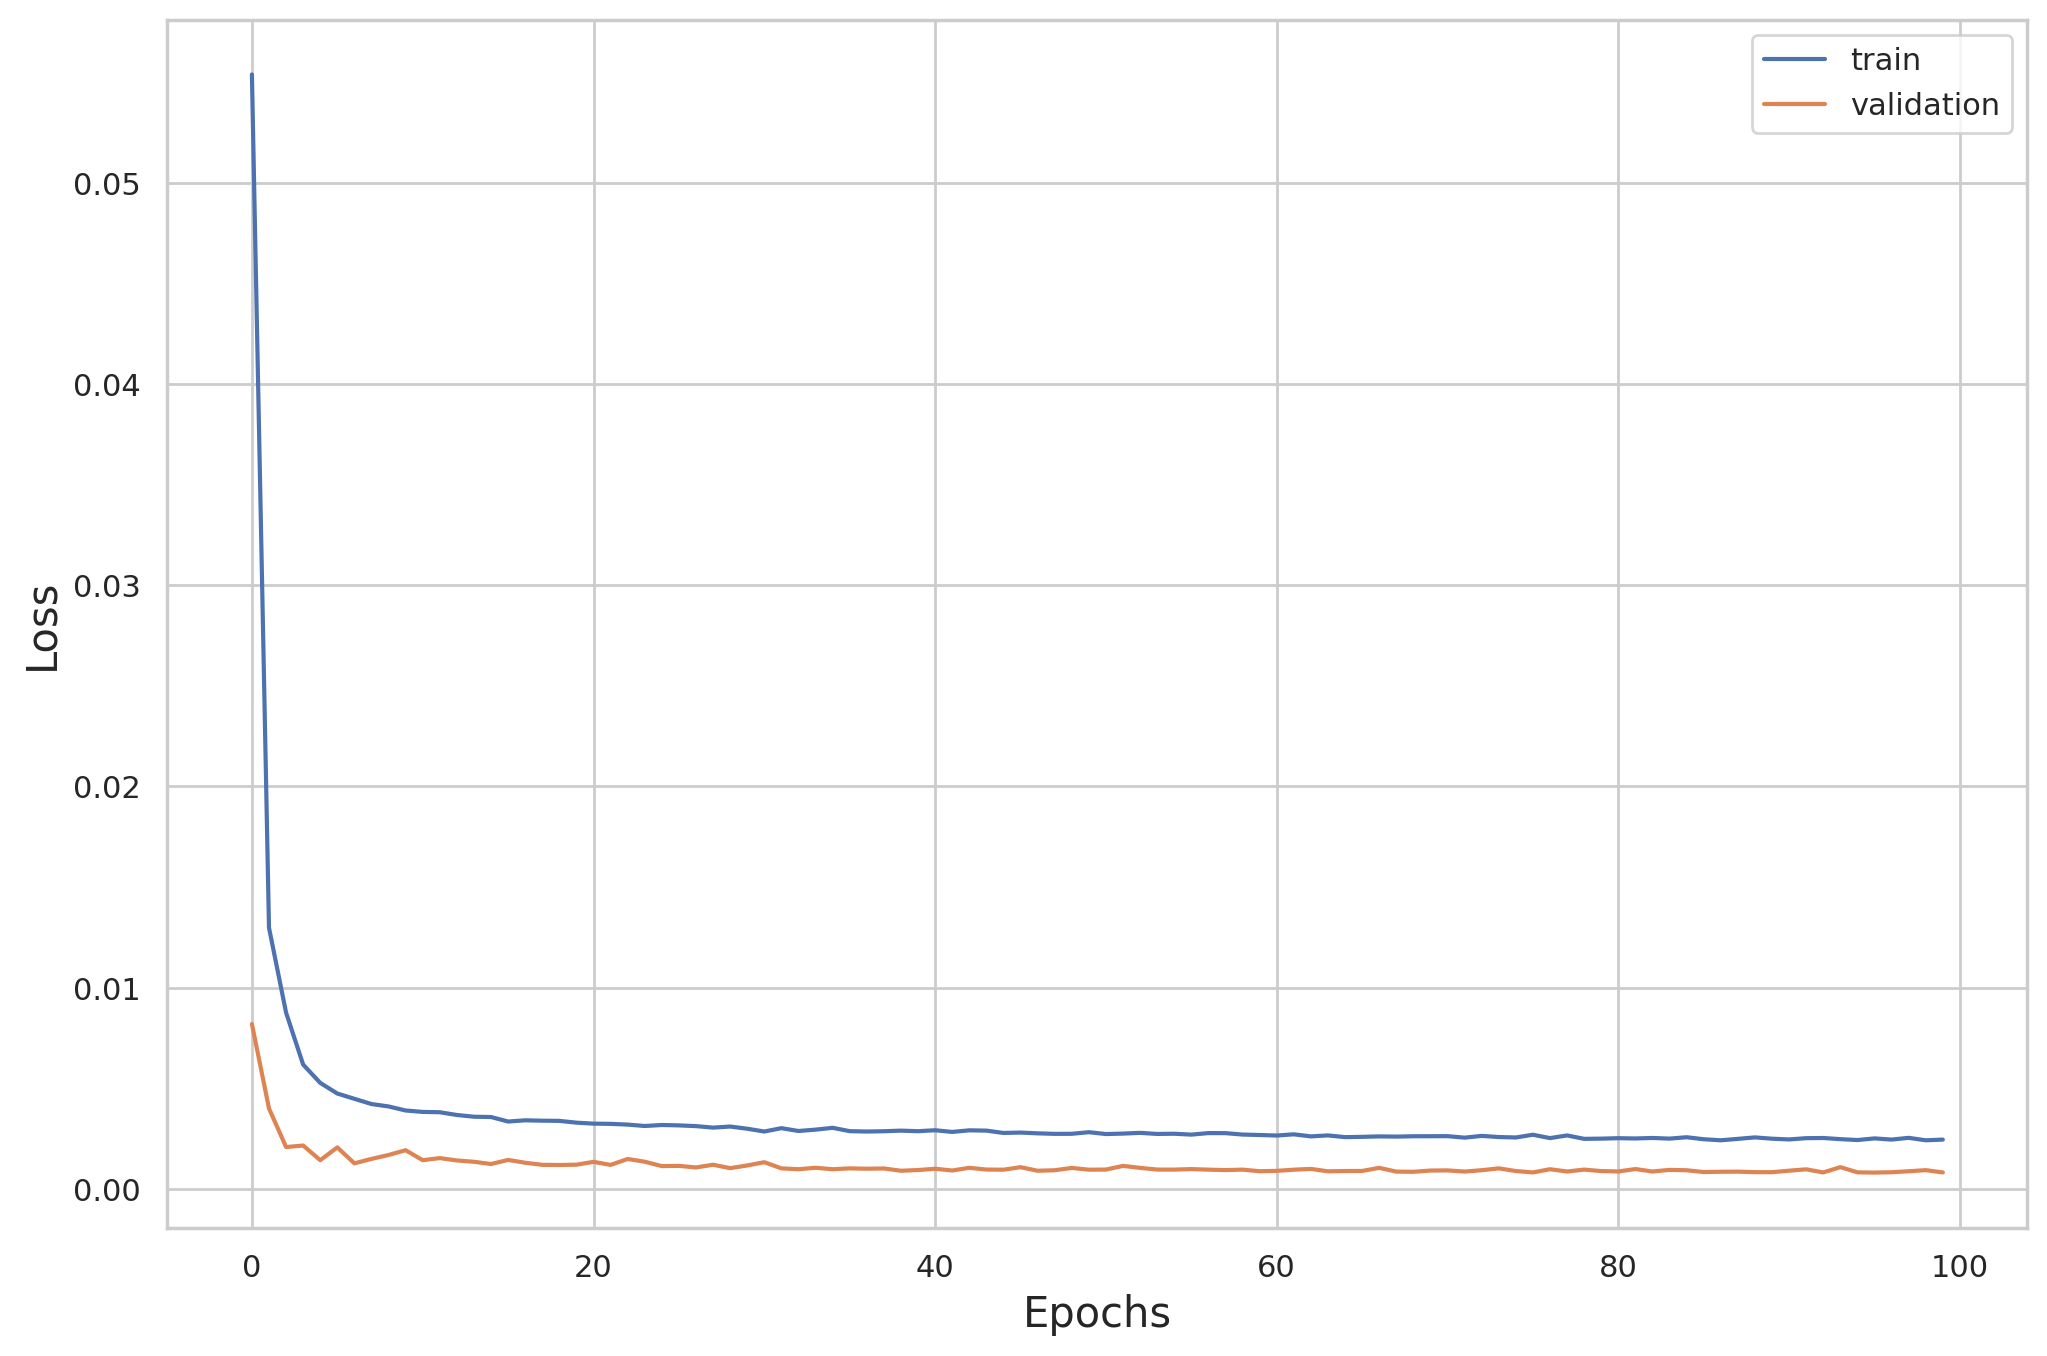

In [357]:
plt.figure(figsize=(12, 8), dpi = 200)
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend()
plt.savefig('loss-validation.png')

In [ ]:
# we need between 20 and 40 epochs to build the model

In [ ]:
# Now it's time to do predictions:

In [340]:
# To predict the first and second row in the test dataset, we need to get the last 2 rows of training.
previous = training[-2:]

In [341]:
previous

array([[0.37382913],
       [0.35707067]])

In [342]:
# checking
training

array([[0.30856786],
       [0.29347866],
       [0.27442316],
       ...,
       [0.40880518],
       [0.37382913],
       [0.35707067]])

In [343]:
inputs = np.concatenate((previous,test), axis = 0) # Now we concatenate the two arrays.

In [359]:
len(inputs)

146

In [345]:
# Time for cerate the array of testing. For every row, we must set 2 predictors
X_test = []
for i in range(2,len(inputs)):
    X_test.append(inputs[i-2:i,0])

In [347]:
X_test = np.array(X_test)

In [348]:
X_test

array([[0.37382913, 0.35707067],
       [0.35707067, 0.05357412],
       [0.05357412, 0.04982646],
       [0.04982646, 0.04879946],
       [0.04879946, 0.04724845],
       [0.04724845, 0.0451094 ],
       [0.0451094 , 0.03967233],
       [0.03967233, 0.03834045],
       [0.03834045, 0.03135011],
       [0.03135011, 0.02795166],
       [0.02795166, 0.02614182],
       [0.02614182, 0.02262482],
       [0.02262482, 0.02313284],
       [0.02313284, 0.02120472],
       [0.02120472, 0.01324923],
       [0.01324923, 0.02044191],
       [0.02044191, 0.01129769],
       [0.01129769, 0.00722555],
       [0.00722555, 0.00525717],
       [0.00525717, 0.00645245],
       [0.00645245, 0.00300233],
       [0.00300233, 0.00405196],
       [0.00405196, 0.00065779],
       [0.00065779, 0.00207028],
       [0.00207028, 0.01019365],
       [0.01019365, 0.00703038],
       [0.00703038, 0.00789778],
       [0.00789778, 0.00700392],
       [0.00700392, 0.00476992],
       [0.00476992, 0.00304114],
       [0.

In [180]:
X_test.shape

(147, 5)

In [349]:
# reshaping for keras input.
x_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [350]:
x_test.shape

(144, 2, 1)

In [351]:
predictions = regressor.predict(X_test)

In [352]:
predictions

array([[0.34799916],
       [0.16519265],
       [0.06207797],
       [0.06154299],
       [0.06032792],
       [0.05867073],
       [0.05434689],
       [0.05369547],
       [0.04811648],
       [0.04591671],
       [0.04472363],
       [0.04206225],
       [0.04272076],
       [0.04115689],
       [0.03509468],
       [0.04127315],
       [0.03364909],
       [0.03112525],
       [0.02988675],
       [0.03092155],
       [0.02823058],
       [0.02923825],
       [0.02661559],
       [0.02788481],
       [0.03401375],
       [0.03104657],
       [0.03191194],
       [0.03117272],
       [0.02953133],
       [0.02836314],
       [0.03002381],
       [0.02749598],
       [0.0294694 ],
       [0.03278226],
       [0.03013512],
       [0.02989775],
       [0.03103849],
       [0.02806985],
       [0.02840108],
       [0.03278479],
       [0.03312269],
       [0.0316982 ],
       [0.03072959],
       [0.03027984],
       [0.02931437],
       [0.0330514 ],
       [0.03057885],
       [0.030

In [353]:
# We need to invert the normalization to get the real results
predictions = normalizer.inverse_transform(predictions)

In [354]:
predictions

array([[17616.012 ],
       [ 9784.971 ],
       [ 5367.7573],
       [ 5344.8403],
       [ 5292.789 ],
       [ 5221.799 ],
       [ 5036.5747],
       [ 5008.6694],
       [ 4769.6772],
       [ 4675.444 ],
       [ 4624.335 ],
       [ 4510.327 ],
       [ 4538.5366],
       [ 4471.5435],
       [ 4211.851 ],
       [ 4476.5234],
       [ 4149.9253],
       [ 4041.809 ],
       [ 3988.7546],
       [ 4033.0833],
       [ 3917.8076],
       [ 3960.9744],
       [ 3848.625 ],
       [ 3902.9958],
       [ 4165.5464],
       [ 4038.4387],
       [ 4075.5093],
       [ 4043.8428],
       [ 3973.529 ],
       [ 3923.4863],
       [ 3994.626 ],
       [ 3886.339 ],
       [ 3970.8762],
       [ 4112.792 ],
       [ 3999.3945],
       [ 3989.2258],
       [ 4038.0928],
       [ 3910.9226],
       [ 3925.1116],
       [ 4112.9004],
       [ 4127.3755],
       [ 4066.353 ],
       [ 4024.86  ],
       [ 4005.594 ],
       [ 3964.2349],
       [ 4124.3213],
       [ 4018.4028],
       [ 4024

In [355]:
# Same thing for the test values because they were normalized before split.
real_values = normalizer.inverse_transform(test)

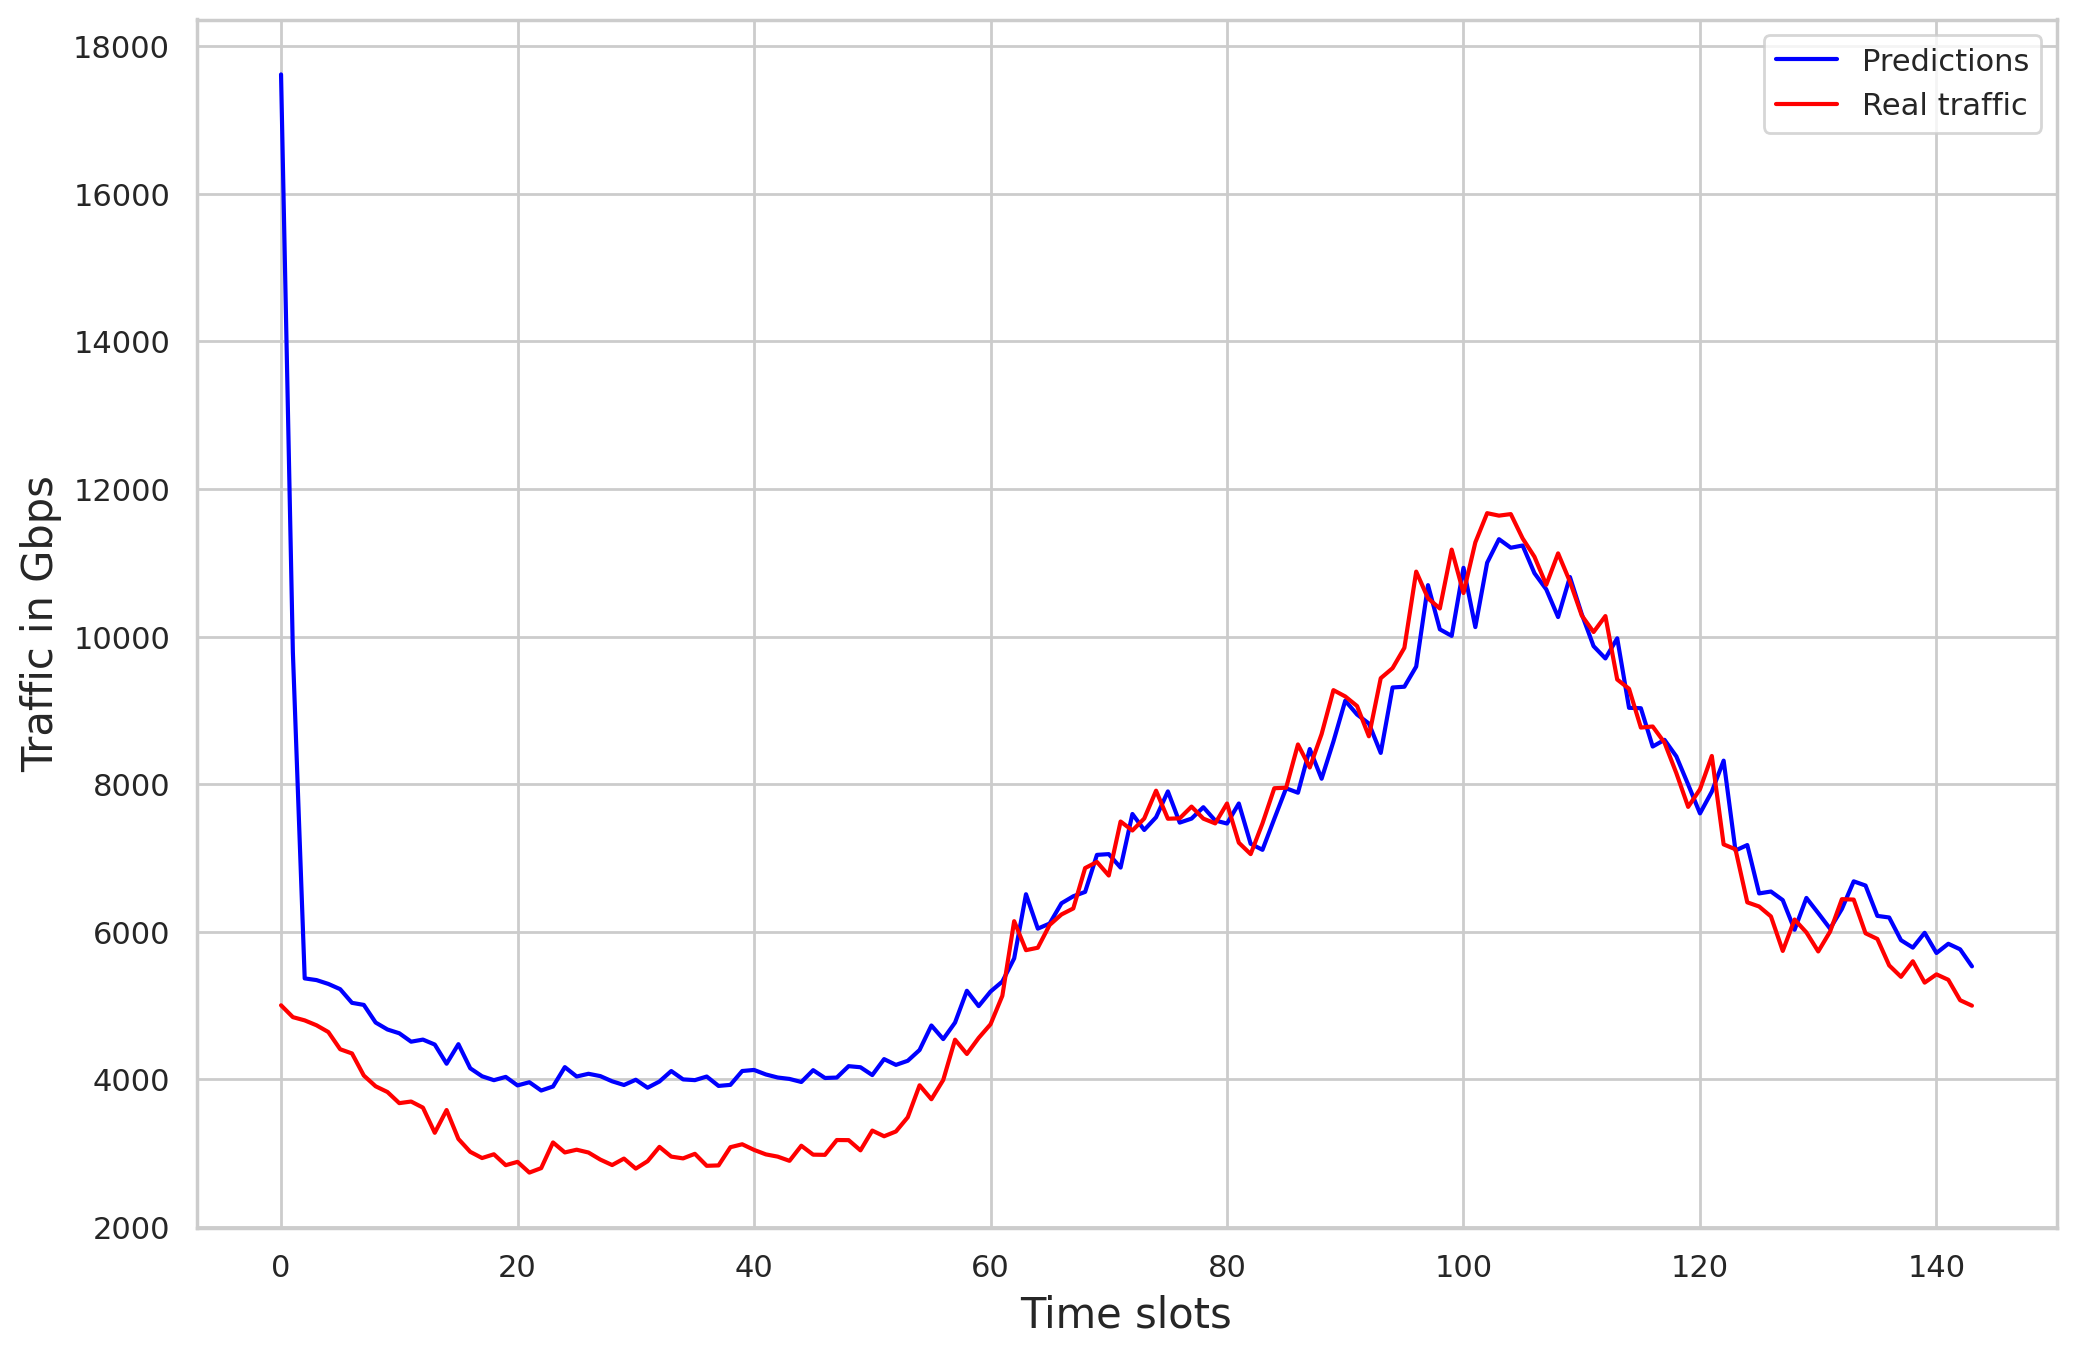

In [360]:
plt.figure(figsize=(12, 8), dpi = 200)
plt.plot(predictions, color = 'blue',label = 'Predictions')
plt.plot(real_values,color = 'red', label = 'Real traffic')
plt.xlabel('Time slots', fontsize = 15)
plt.ylabel('Traffic in Gbps', fontsize = 15)
plt.legend()

Now, getting the true time intervals

In [361]:
df7 = dataset[-144:]

In [362]:
df7.head()

,Time_Interval,Fronthaul_Gbps
4176,0.0,5003.470948
4177,0.1,4842.929331
4178,0.2,4798.934783
4179,0.3,4732.492895
4180,0.4,4640.860460


In [363]:
df7['Predicted_values'] = predictions

/home/nilton/anaconda3/envs/Jedi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [372]:
df7 = df7[2:]

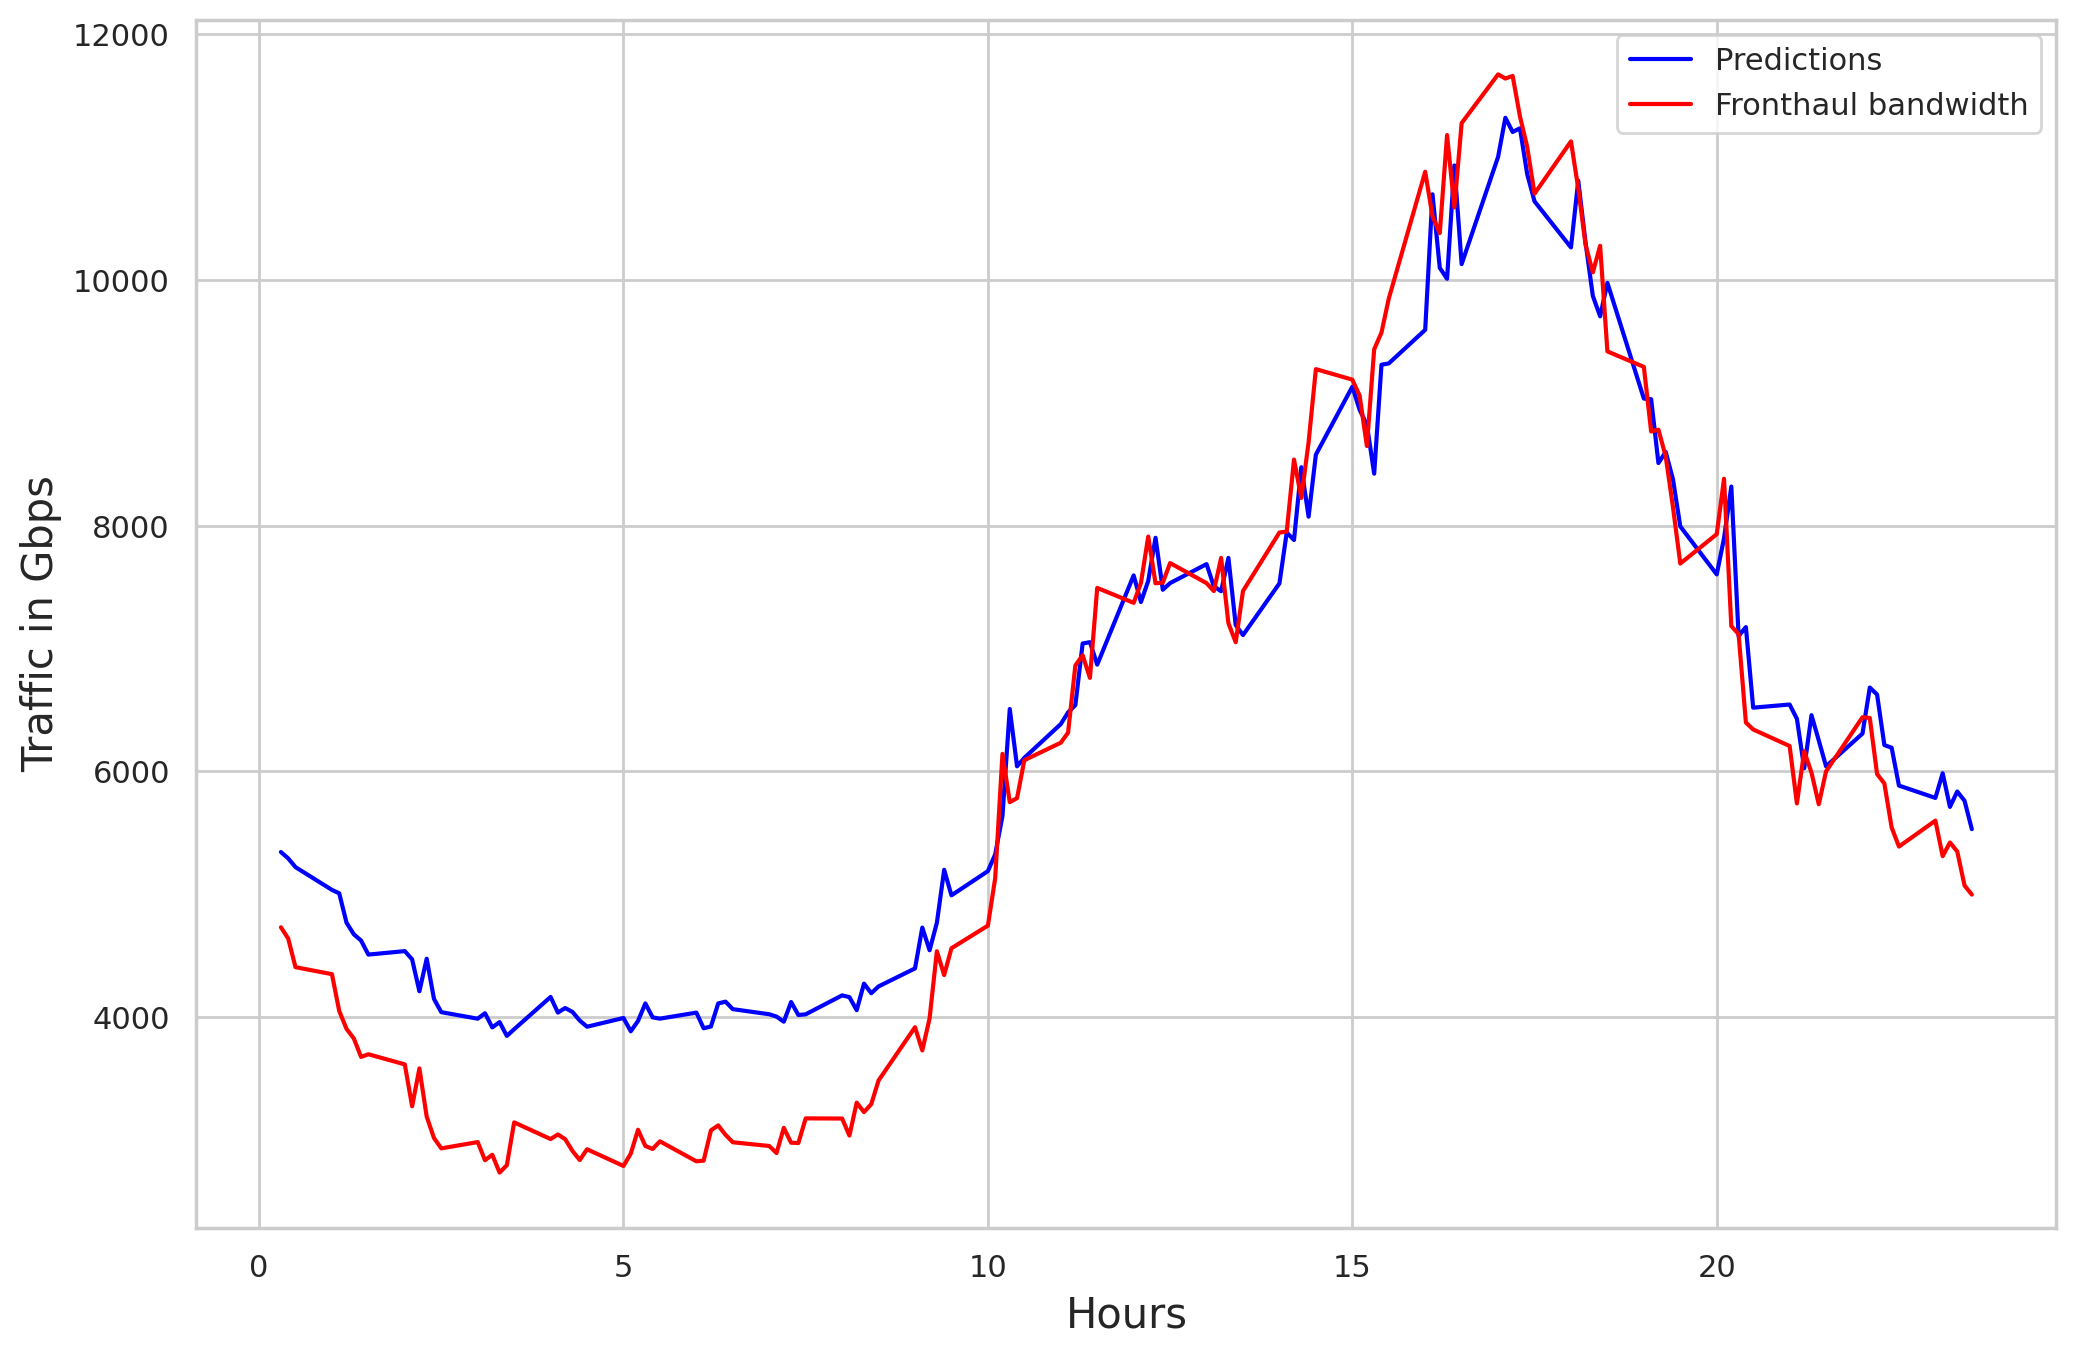

In [373]:
plt.figure(figsize=(12, 8), dpi = 200)
plt.plot(df7['Time_Interval'],df7['Predicted_values'], color = 'blue',label = 'Predictions')
plt.plot(df7['Time_Interval'],df7['Fronthaul_Gbps'], color = 'red',label = 'Fronthaul bandwidth')
plt.xlabel('Hours', fontsize = 15)
plt.ylabel('Traffic in Gbps', fontsize = 15)
plt.legend()
plt.savefig('Predictions.png')

In [375]:
r2_score(real_values, predictions)

0.7542534638688336

# Now we've finally answered the second question: can we predict when the traffic will reach the fiber limit? We can build a model of a recurrent neural network to predict the traffic 10 minutes ahead. As we can see in the image above, the model can keep up with traffic tendencies and, thereby, predict when it will reach the fiber limit or not.

Summarizing: We saw in this project:
data cleaning
exploratory analysis (Statistical analysis)
data transformation
preprocessing for ML models
Deep learning (LSTM)
Time series